In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
from sklearn import preprocessing
import math
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [3]:
def cbrt(a):#python 不可以给负数开根，用此函数可以
    b = np.zeros(a.shape)
    for i in range(len(a)):
        s = -1 if a[i] < 0 else 1
        b[i]=s * (a[i]*s) ** (1/3)
    return b
#使用lof算法剔除余数利群点
def lof_sample(input,k,p):
    remainder_samples = input.shape[0]%k
    if remainder_samples == 0:
        return list(range(0,input.shape[0]))
    lof_model = LocalOutlierFactor(n_neighbors=10,p=p)
    lof_model.fit_predict(input)
    score = abs(lof_model.negative_outlier_factor_)
    return np.argsort(score)[:-remainder_samples]

#AMLI聚类
def subspace_division(input,output,k,p=2,lof=False,add_y=False):
    data = np.hstack((input,output))
    n_output = output.shape[1]
    if lof==True and add_y==False:
        lof_index = lof_sample(input,k,p)
        data = data[lof_index]
    elif lof==True and add_y==True:
        lof_index = lof_sample(data,k,p)
        data = data[lof_index]
    m = data.shape[0]
    if add_y == False:
        min_point = np.min(data[:,:-n_output],axis=0)#特征空间最小点
        ls = []
        for i in range(m):
            if i%k == 0:
                point_list = []
            distance_min = np.linalg.norm(data[:,:-n_output]-min_point,axis=1,ord=p)
            nearest_point = np.argmin(distance_min)
            point_list.append(data[nearest_point])
            data = np.delete(data,nearest_point,axis=0)
            min_point = np.mean(point_list,axis=0)[:-1]
            if len(point_list)==k or data.shape[0]==0:
                ls.append(point_list)
    else:
        min_point = np.min(data,axis=0)#特征空间最小点
        ls = []
        for i in range(m):
            if i%k == 0:
                point_list = []
            distance_min = np.linalg.norm(data-min_point,axis=1,ord=p)
            nearest_point = np.argmin(distance_min)
            point_list.append(data[nearest_point])
            data = np.delete(data,nearest_point,axis=0)
            min_point = np.mean(point_list,axis=0)
            if len(point_list)==k or data.shape[0]==0:
                ls.append(point_list)
    return ls

#簇心插值排序
def index_sort(input,output,k,p=2,lof=False,add_y=False):
    ls = subspace_division(input=input,output=output,k=k,p=p,lof=lof,add_y=add_y)
    data = np.hstack((input,output))
    n_output = output.shape[1]
    if add_y == True:
        cluster_mean = np.vstack((np.mean(ls[:-1],axis=1),np.mean(ls[-1],axis=0)))#每个簇的簇心
        min_point = np.min(data,axis=0)
        ls_sort = []
        for _ in range(cluster_mean.shape[0]):
            distance_min = np.linalg.norm(cluster_mean-min_point,axis=1,ord=p)
            nearest_cluster = np.argmin(distance_min)
            ls_sort.append(ls[nearest_cluster])
            min_point = cluster_mean[nearest_cluster,:]
            ls.pop(nearest_cluster)
            cluster_mean = np.delete(cluster_mean,nearest_cluster,axis=0)
    else:
        cluster_mean = np.vstack((np.mean(ls[:-1],axis=1)[:,:-n_output],np.mean(ls[-1],axis=0)[:-n_output]))#每个簇的簇心
        min_point = np.min(data[:,:-1],axis=0)
        ls_sort = []
        for _ in range(cluster_mean.shape[0]):
            distance_min = np.linalg.norm(cluster_mean-min_point,axis=1,ord=p)
            nearest_cluster = np.argmin(distance_min)
            ls_sort.append(ls[nearest_cluster])
            min_point = cluster_mean[nearest_cluster,:]
            ls.pop(nearest_cluster)
            cluster_mean = np.delete(cluster_mean,nearest_cluster,axis=0)
    return ls_sort

#AMLI插值
def AMLI_method(input,output,k=4,eta=1,p=2,lof=False,fit_method="linear",add_y=False):
    ls_sort = index_sort(input,output,k,p,lof,add_y)
    n_output = output.shape[1]
    model = LinearRegression() if fit_method == "linear" else SVR()
    point = []
    for i in range(0,len(ls_sort)):
        if i == len(ls_sort)-1:
            break
        cluster1 = np.array(ls_sort[i])
        cluster2 = np.array(ls_sort[i+1])
        x = np.vstack((cluster1,cluster2))[:,:-1]
        y = np.vstack((cluster1,cluster2))[:,-1]
        model.fit(x,y)
        pred1_sign_index = np.argsort(model.predict(cluster1[:,:-n_output])-cluster1[:,-n_output])
        pred2_sign_index = np.argsort(model.predict(cluster2[:,:-n_output])-cluster2[:,-n_output])
        for k in range(min(pred1_sign_index.shape[0],pred2_sign_index.shape[0])):
            if add_y == True:
                distance = np.linalg.norm(cluster1[pred1_sign_index[k]]-cluster2[pred2_sign_index[-k-1]],ord=p)
            else:
                distance = np.linalg.norm(cluster1[pred1_sign_index[k]][:-n_output]-cluster2[pred2_sign_index[-k-1]][:-n_output],ord=p)
            add_sample = np.linspace(cluster1[pred1_sign_index[k]],cluster2[pred2_sign_index[-k-1]],max(np.int(eta*distance),2))
            point.append(add_sample)
    sample = point[0]
    for i in range(len(point)):
        if i == len(point)-1:
            break
        sample = np.vstack((sample,point[i+1]))
    return sample



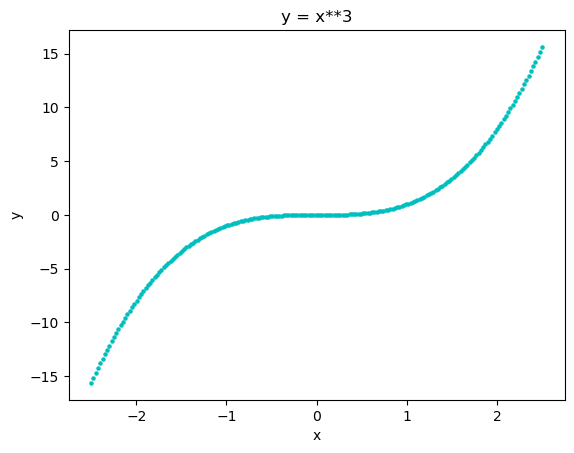

beford MSE131.03181869264745
after MSE:99.44526867652688


(3808, 2)

In [14]:
np.random.seed(124)
n = 200#sample size
x = np.linspace(2.5,-2.5,n)
y = x**3
x1 = x+np.random.randn(n)
x1 = x1.reshape(n,-1)
y1 = y+np.random.randn(n)
y = y.reshape(n,-1)
y1 = y1.reshape(n,-1)
sample = AMLI_method(x1,y1,6,100,p=2,lof=True,add_y=False,fit_method="linear")
plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x,y,color="c",s=5)
plt.title("y = x**3")
plt.show()
mse1 = np.sum((x1**3-y1)**2)/x1.shape[0]
mse2 = np.sum((sample[:,0]**3-sample[:,1])**2)/sample.shape[0]
print(f"beford MSE{mse1}\nafter MSE:{mse2}")
sample.shape

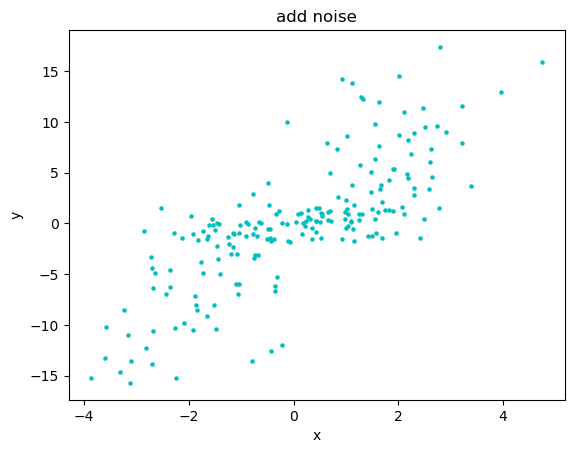

In [15]:
plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x1,y1,color="c",s=5)
plt.title("add noise")
plt.show()

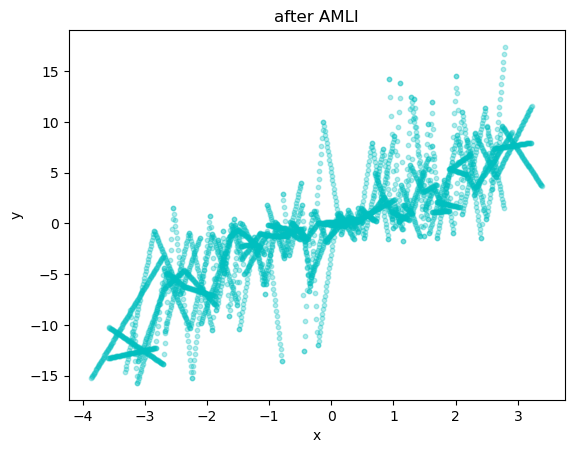

In [16]:
plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(sample[:,0],sample[:,1],color="c",s=10,alpha=0.3)
plt.title("after AMLI")
plt.show()

Text(0.5, 1.0, 'processed data')

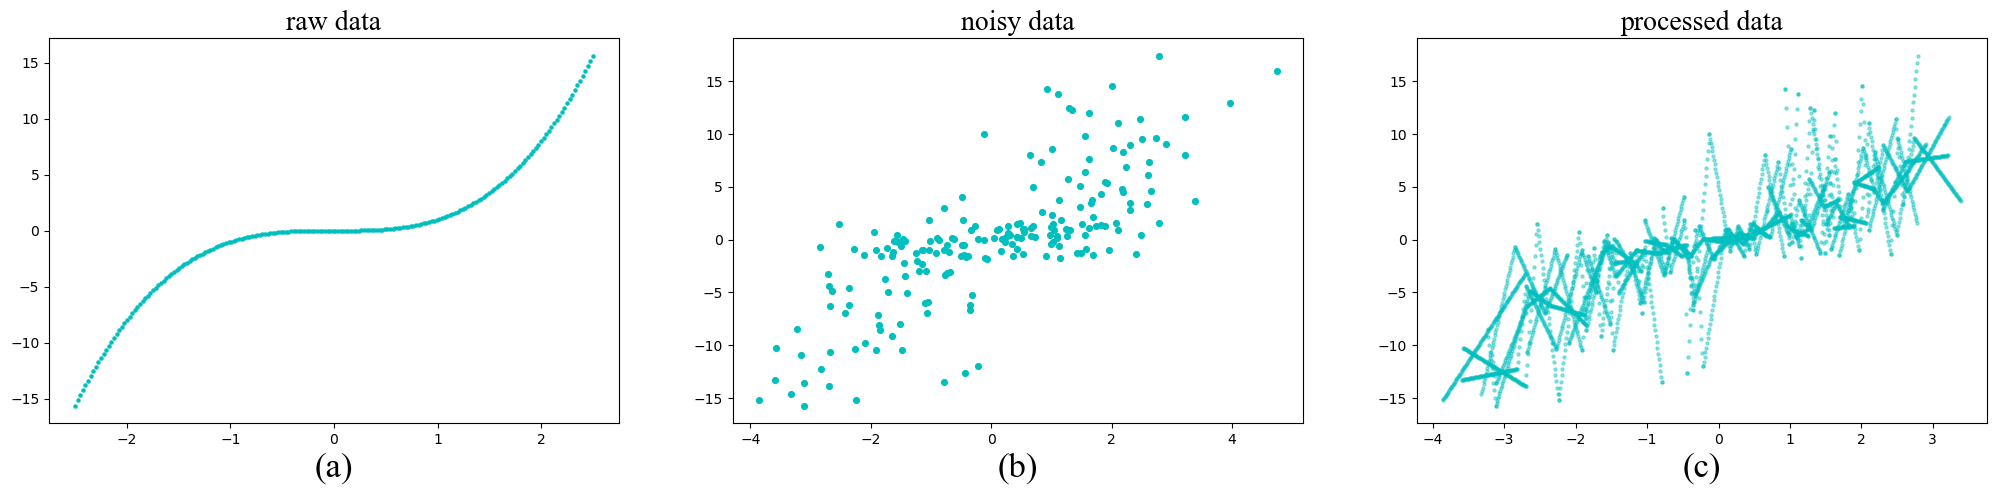

In [75]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,5))
axes[0].scatter(x,y,color="c",s=5)
axes[0].set_xlabel("(a)",fontproperties='Times New Roman',size=25)
# axes[0].set_ylabel("y",fontproperties='Times New Roman')
axes[1].scatter(x1,y1,color="c",s=17,alpha=1)
axes[1].set_xlabel("(b)",fontproperties='Times New Roman',size=25)
# axes[1].set_ylabel("y",fontproperties='Times New Roman')
axes[2].scatter(sample[:,0],sample[:,1],color="c",s=5,alpha=0.4)
axes[2].set_xlabel("(c)",fontproperties='Times New Roman',size=25)
# axes[2].set_ylabel("y",fontproperties='Times New Roman')
axes[0].set_title("raw data",size=20,fontproperties='Times New Roman')
axes[1].set_title("noisy data",size=20,fontproperties='Times New Roman')
axes[2].set_title("processed data",size=20,fontproperties='Times New Roman')

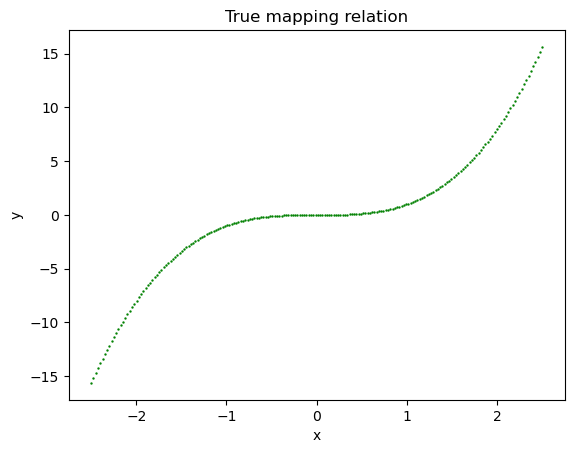

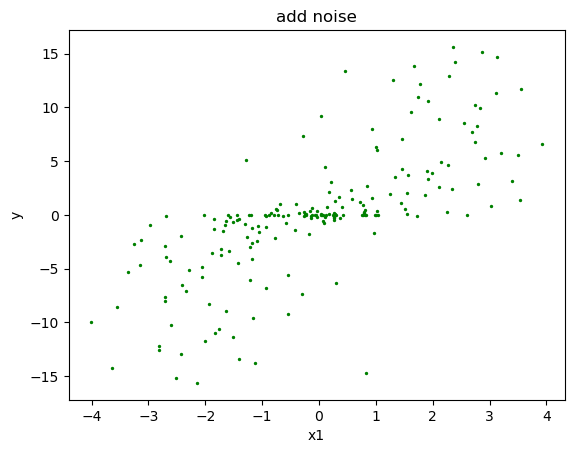

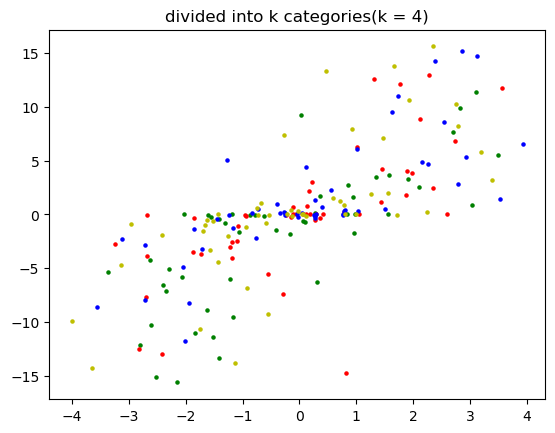

after AMLI method, the number of simple: 2964


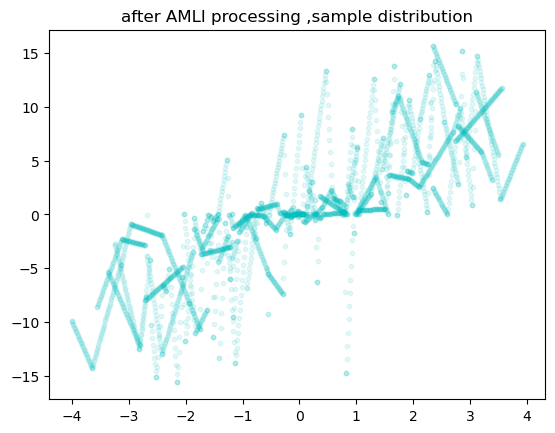

In [9]:
def devide_sample(x_train,y_train,spoches):
        index_spoches = np.zeros(len(x_train)-len(x_train)%spoches)
        index_list = list(range(0,len(x_train)))
        for i in range(len(x_train)-len(x_train)%spoches):
            index = np.random.choice(index_list)
            index_spoches[i] = index
            index_list.remove(index)
        index_spoches = index_spoches.reshape(spoches,int((len(x_train)-(len(x_train)%spoches))/spoches)).astype(int)
        return index_spoches
n = 200#sample size
x = np.linspace(2.5,-2.5,n)
y = x**3
plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x,y,color="green",s=0.5)
plt.title("True mapping relation")
plt.show()
x1 = x+np.random.normal(0,1,n)
plt.figure()
plt.xlabel("x1")
plt.ylabel("y")
plt.scatter(x1,y,color="green",s=2)
plt.title("add noise")
plt.show()
spoches = 4 # hyperparameters K
index = devide_sample(x1,y,spoches)
plt.figure()
a = ["green","red","b","y"]
for i in range(4):
    index1 = np.argsort(x1[index[i]])
    plt.scatter(x1[index[i][index1]],y[index[i][index1]],color=a[i],s=5)
    plt.title("divided into k categories(k = 4)")
plt.show()
#AMLI method
eta = 100#one of the hyperparameters in AMLI method
x_point=[]
y_point=[]
for k in range(spoches):
    x_set = x1[index[k]]
    y_set = y[index[k]]
    sort_index = np.argsort(x_set)
    for i in range(len(x_set)):
        if i == len(x_set)-1:
            continue
        cha = eta*(x_set[sort_index[i+1]]-x_set[sort_index[i]])
        # cha = eta*(x_set[sort_index[i+1]]-x_set[sort_index[i]])
        x_point.append(np.linspace(x_set[sort_index[i]],x_set[sort_index[i+1]],int(cha)))
        y_point.append(np.linspace(y_set[sort_index[i]],y_set[sort_index[i+1]],int(cha)))
for i in x_point:
    x1 = np.hstack((x1,i))
for i in y_point:
    y = np.hstack((y,i))
a,i = 0,0
for i in range(x1.shape[0]):
    a += round((round(y[i]**(1/3),3)-x1[i])**2,3)
    i += 1
    if i ==98:
        break
print(f"after AMLI method, the number of simple: {x1.shape[0]}")
plt.figure()
plt.scatter(x1,y,color="c",s=10,alpha=0.1)
plt.title("after AMLI processing ,sample distribution")
plt.show()

In [57]:
#AMLI method
class AMLI_method:
    
    def __init__(self,spoches=4,distance=2,number_parameter=2):
        self.spoches = spoches
        self.distance = distance
        self.number_parameter = number_parameter
        
    def _distance(self,x1,x2):
        if x1.ndim >1 or x2.ndim>1:
            return np.linalg.norm(x1-x2,ord = self.distance,axis=1)
        else:
            return np.linalg.norm(x1-x2,ord = self.distance)
        
    def devide_sample(self,x_train,y_train):#dividing k sets
        index_spoches = np.zeros(len(x_train)-len(x_train)%self.spoches)
        index_list = list(range(0,len(x_train)))
        for i in range(len(x_train)-len(x_train)%self.spoches):
            index = np.random.choice(index_list)
            index_spoches[i] = index
            index_list.remove(index)
        self.index_spoches = index_spoches.reshape(self.spoches,
                                                   int((len(x_train)-(len(x_train)%self.spoches))/self.spoches)).astype(int)
        self.x_train = x_train
        self.y_train = y_train
        
    def k_interpolate(self):#K-linear interpolation filling
        x_point = []
        y_point = []
        for k in range(self.spoches):
            xk_set = self.x_train[self.index_spoches[k]]
            yk_set = self.y_train[self.index_spoches[k]]
            distance = np.linalg.norm(xk_set,ord=self.distance,axis=1)
            xk_set = xk_set[np.argsort(distance)]
            yk_set = yk_set[np.argsort(distance)]
            remaining_xset = xk_set
            remaining_yset = yk_set
            for i in range(len(xk_set)):
                if i == len(xk_set)-1:
                    continue
                elif i == 0:
                    point_x = xk_set[i]
                    point_y = yk_set[i]
                    remaining_xset = remaining_xset[1:]
                    remaining_yset = remaining_yset[1:]
                distance = self._distance(point_x,remaining_xset)
                min_index = np.argmin(distance)
                x_point.append((np.linspace(point_x,remaining_xset[min_index],int(self.number_parameter*distance[min_index]))))
                y_point.append((np.linspace(point_y,remaining_yset[min_index],int(self.number_parameter*distance[min_index]))))
                point_x = remaining_xset[min_index]
                point_y = remaining_yset[min_index]
                remaining_xset = np.delete(remaining_xset,min_index,axis=0)
                remaining_yset = np.delete(remaining_yset,min_index,axis=0)
        for i in x_point:
            self.x_train = np.vstack((self.x_train,i))
        for i in y_point:
            self.y_train = np.hstack((self.y_train,i))
        
        return self.x_train,self.y_train

In [21]:
n = 7000#sample size
k = 25#hyperparameters K
eta = 5#hyperparameters eta
train_data = pd.read_csv(r"/Users/dyk/Desktop/AMLI V2/CASP.csv")
X = train_data.iloc[:n,1:].values
y = train_data.iloc[:n,0].values.reshape(-1,1)
X = X+np.random.normal(0,5,(X.shape))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
y = min_max_scaler.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=113)
data = AMLI_method(x_train,y_train,60,40,p=2,lof=True,add_y=False,fit_method="linear")
a1 = data[:,:-1]
b1 = data[:,-1]
print(f"Initial sample size: {X.shape[0]} , after AMLI method sample size: {a1.shape[0]}")

Initial sample size: 7000 , after AMLI method sample size: 46441


In [69]:
#knn
from sklearn import neighbors
for k in range(1,140,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train,y_train)
    y_pred = modelKNN.predict(x_test)
    print("before AMLI , k:",(k),",  MSE:",(mean_squared_error(y_pred,y_test)))
for k in range(1,120,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(a1,b1)
    y_pred = modelKNN.predict(x_test)
    print("after AMLI , k:",(k),",  MSE:",(mean_squared_error(y_pred,y_test)))

before AMLI , k: 1 ,  MSE: 0.10387652344529977
before AMLI , k: 6 ,  MSE: 0.06260743133334423
before AMLI , k: 11 ,  MSE: 0.05761176443767702
before AMLI , k: 16 ,  MSE: 0.056020520811722076
before AMLI , k: 21 ,  MSE: 0.0549841874516655
before AMLI , k: 26 ,  MSE: 0.054289306095275
before AMLI , k: 31 ,  MSE: 0.053797133957836855
before AMLI , k: 36 ,  MSE: 0.05350254968237077
before AMLI , k: 41 ,  MSE: 0.053301126918764985
before AMLI , k: 46 ,  MSE: 0.05299182508951218
before AMLI , k: 51 ,  MSE: 0.05290935355958881
before AMLI , k: 56 ,  MSE: 0.05293744562620088
before AMLI , k: 61 ,  MSE: 0.052789941622295375
before AMLI , k: 66 ,  MSE: 0.05276563265888883
before AMLI , k: 71 ,  MSE: 0.05272609427087508
before AMLI , k: 76 ,  MSE: 0.052681451695762126
before AMLI , k: 81 ,  MSE: 0.052570290439935954
before AMLI , k: 86 ,  MSE: 0.05252844323689569
before AMLI , k: 91 ,  MSE: 0.05248469716095278
before AMLI , k: 96 ,  MSE: 0.05243124885684851
before AMLI , k: 101 ,  MSE: 0.05243636

In [22]:
#fnn
from sklearn.neural_network import MLPRegressor
model =MLPRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
mes1 = mean_squared_error(y_pred,y_test)
model =MLPRegressor()
model.fit(a1,b1)
y_pred = model.predict(x_test)
mes2 = mean_squared_error(y_pred,y_test)
print("before AMLI MSE:%f\nafter AMLI MSE:%f"%(mes1,mes2))

before AMLI MSE:0.061433
after AMLI MSE:0.057719


In [52]:
#GBDT
from sklearn.ensemble import GradientBoostingRegressor
for i in range(10,300,20):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train,y_train)
    y_pred = model2.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))
for i in range(10,300,20):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(a1,b1)
    y_pred = model2.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))

before AMLI, loss:0.051690 , n_estimators:10
before AMLI, loss:0.051694 , n_estimators:30
before AMLI, loss:0.051755 , n_estimators:50
before AMLI, loss:0.051864 , n_estimators:70
before AMLI, loss:0.052026 , n_estimators:90
before AMLI, loss:0.052064 , n_estimators:110
before AMLI, loss:0.052142 , n_estimators:130
before AMLI, loss:0.052325 , n_estimators:150
before AMLI, loss:0.052439 , n_estimators:170
before AMLI, loss:0.052659 , n_estimators:190
before AMLI, loss:0.052666 , n_estimators:210
before AMLI, loss:0.052885 , n_estimators:230
before AMLI, loss:0.053030 , n_estimators:250
before AMLI, loss:0.053192 , n_estimators:270
before AMLI, loss:0.053318 , n_estimators:290
after AMLI, loss:0.051747 , n_estimators:10
after AMLI, loss:0.051762 , n_estimators:30
after AMLI, loss:0.051748 , n_estimators:50
after AMLI, loss:0.051802 , n_estimators:70
after AMLI, loss:0.051932 , n_estimators:90
after AMLI, loss:0.051957 , n_estimators:110
after AMLI, loss:0.051947 , n_estimators:130


KeyboardInterrupt: 

In [44]:
#RF
from sklearn.ensemble import RandomForestRegressor
for i in range(1,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train,y_train)
    y_pred = regressor.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))
for i in range(1,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(a1, b1)
    y_pred = regressor.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_squared_error(y_test,y_pred),i))

before AMLI, loss:0.004130 , n_estimators:1
before AMLI, loss:0.002245 , n_estimators:21
before AMLI, loss:0.002218 , n_estimators:41
before AMLI, loss:0.002204 , n_estimators:61
before AMLI, loss:0.002202 , n_estimators:81
before AMLI, loss:0.002192 , n_estimators:101
before AMLI, loss:0.002194 , n_estimators:121
before AMLI, loss:0.002189 , n_estimators:141
before AMLI, loss:0.002184 , n_estimators:161
before AMLI, loss:0.002184 , n_estimators:181
after AMLI, loss:0.003580 , n_estimators:1
after AMLI, loss:0.002373 , n_estimators:21
after AMLI, loss:0.002338 , n_estimators:41
after AMLI, loss:0.002340 , n_estimators:61


KeyboardInterrupt: 